# Quasi-Random Search for Hyperparameter Optimisation

*Alexandra Stepanenko, MSc Data Science*

### Contents

1. [Introduction](#introduction)    
    1.1 [Random search](#introductionrs)  
    1.2 [Dataset](#introductionds)  
2. [Hyperparameter optimisation program design](#design)   
    2.1 [Basic model structure](#designbasic)  
    2.2 [Architecture choices for the optimisation program](#designarc)  
3. [Running the program](#run)  
4. [Evaluating the best performing model using test data](#test)
5. [Conclusion and evaluation](#conclusion)
6. [References](#references)

In [1]:
# We need to update google colab's version of scipy to use the qmc (Quasi-Monte Carlo) submodule

!pip3 install scipy==1.7.3

     |████████████████████████████████| 38.1 MB 1.2 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
# Import required libraries and modules

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers, optimizers, regularizers
import numpy as np
from scipy.stats.qmc import Sobol
from scipy.stats import qmc
import random
import keras
import time

In [3]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [4]:
# Set graphs to a seaborn style
sns.set_style('dark')

# 1 Introduction <a class="anchor" id="introduction"></a>

## 1.1 Random search <a class="anchor" id="introductionrs"></a>

In this project, I create a hyperparameter optimisation program based on the Random Search method by Bergstra and Bengio from their 2012 paper 'Random search for hyper-parameter optimization' [1].

Random search has proven a simple but effective method of hyperparameter optimisation, having an advantage over grid search in that random search will trial a greater number of distinct values for each individual hyperparameter. Bergstra and Bengio argue that only some of the hyperparameters are important for each problem (although which hyperparameters this will be is not predictable), therefore it is an effective strategy to represent as many distinct values as possible for each hyperparameter in order to find values in the region of the optimum for the most important hyperparameters. 

In their experiements, which were based on simulations, Bergstra and Bengio found using quasirandom sequences (also known as low-discrepancy sequences) to choose 'random' hyperparameter values rather than pseudorandom numbers gave a slight improvement to hyperparameter optimisation results. In particular, Sobol sequences were highlighted as effective. Quasirandom sequences can be thought of as containing numbers which have equal distance ± a small error from one another. This means the distribution is not rigid as per a Grid Search. Simultaneously, quasirandom numbers are distributed much more evenly even across a range when compared to pseudorandom (or true random) numbers. This is advantageous as the nature of pseudorandom numbers means the distribution can risk creating blind spots of unsearched spaces. In this hyperparameter optimisation program I will use quasirandom numbers rather than pseudorandom numbers.

We can create Sobol sequences using the SciPy library. Technically, the sample size of a Sobol sequence should be a power of two (i.e. $n = 2^{m}$) to ensure the full balanced properties of the sequence. However, by using a scrambled sequence, we can create a sample size of any arbitary $n$ [2]. For our purposes, it is not critical for the Sobol sequence to be perfectly balanced - sequences generated with scrambling and using any arbitary $n$ will still have low discrepancy compared to pseudorandom number generators (for example, NumPys's Random Generator). We can demonstrate this graphically.

First let's have a look how the distribution of numbers look when using a pseudorandom generated set of numbers:

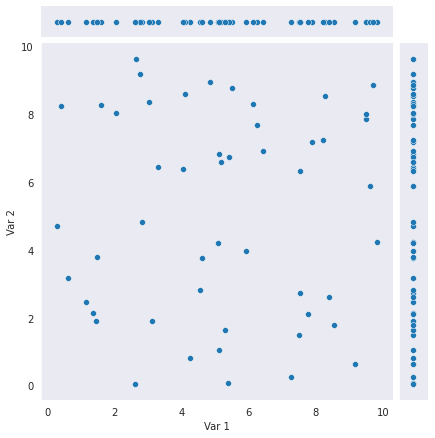

In [5]:
# Using NumPy to create a sequence of pseudorandom numbers
random_generator = np.random.default_rng(seed=1)

# Create 50 sets of random value pairs using NumPy, scaled to between 0 and 10 using SciPy's scale function
rand_coords = qmc.scale(random_generator.random((2, 50)), [0 for n in range(0,50)], [10 for n in range(0,50)])
random_sample = pd.DataFrame({'Var 1': rand_coords[0], 'Var 2': rand_coords[1]})

g = sns.JointGrid(ratio = 10)
sns.scatterplot(data = random_sample, x = 'Var 1', y = 'Var 2', ax=g.ax_joint)
sns.scatterplot(data = random_sample, x = 'Var 1', y = 1 , ax=g.ax_marg_x)
sns.scatterplot(data = random_sample, y = 'Var 2', x = 1 , ax=g.ax_marg_y)
plt.show()

We can see that there are some large gaps, and some sets of points are clustered closely together. Next let's have a look at the distribution when using quasirandom numbers:

/usr/local/lib/python3.7/dist-packages/scipy/stats/_qmc.py:1078: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"


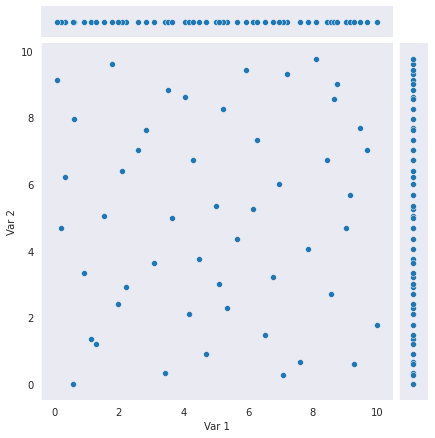

In [6]:
# Create Sobol sampler with dimension two (this means sequences will be created in list pairs of two)
sampler = Sobol(d=2, scramble=True, seed=17)

# Get a sequence of 50 scrambled numbers and scale them to be between 0 and 10
sobol_seqs = qmc.scale(sampler.random(50), [0, 0], [10, 10])

# Reformat into plottable coordinates
sobol_x = []
sobol_y = []

for i in sobol_seqs:
    sobol_x.append(i[0])
    sobol_y.append(i[1])

sobol_sample = pd.DataFrame({'Var 1': sobol_x, 'Var 2': sobol_y})
    
# Plot 
g = sns.JointGrid(ratio = 10)
sns.scatterplot(data = sobol_sample, x = 'Var 1', y = 'Var 2', ax=g.ax_joint)
sns.scatterplot(data = sobol_sample, x = 'Var 1', y = 1 , ax=g.ax_marg_x)
sns.scatterplot(data = sobol_sample, y = 'Var 2', x = 1 , ax=g.ax_marg_y)

We can see the Sobol distribution has a lot less gaps, both in the 1D space of each individual variable, and in the 2D space of variable intersection.

## 1.2 Dataset <a class="anchor" id="introductionds"></a>

### 1.2.1 Fashion-MNIST

The dataset I will be testing my hyperparameter optimisation program with is Fashion-MNIST. 

Fashion-MNIST is a multiclass single-label classification problem with balanced classes and a large enough number of samples to use hold-out validation. As we are doing multiclass single-label classification, we will use categorical crossentropy as the loss function, with a softmax last-layer activation. As the dataset is balanced, we will use accuracy as the test performance  metric. Any other datasets with the same characteristics as Fashion-MINST outlined above could also be used with this program.

### 1.2.2 Preprocessing

In [16]:
# Import fashion-minst from the tensorflow bank of datasets
from tensorflow.keras.datasets import fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [17]:
# Preprocessing the images into vectors, and converting values to a float between 0 and 1
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255

In [18]:
# One-hot encode the labels
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [19]:
# Creating training and validation datasets
x_valid = train_images[:10000]
x_train = train_images[10000:]
y_valid = train_labels[:10000]
y_train = train_labels[10000:]

# 2 Hyperparameter optimisation program design <a class="anchor" id="design"></a>

## 2.1 Basic model structure <a class="anchor" id="designbasic"></a>

The model created will be a sequential model with up to five hidden dense layers (and up to five drop out layers).

The following will be optimised:

* Number of hidden layers (up to 5)
* Number of neurons in hidden layers
* Activation functions
* Learning rate
* Optimizer momentum 
* Batch size 
* Dropout layer dropout rate

The first thing we need to build our optimisation program is a function which can take the hyperparameters of a model, build and run the model, and return the history dictionary. I define such a function below. This function has a parameter `model_type`: when this is defined as 'Trials', the model will be fitted with partial training data, and validated on hold out data from the training set, with the history dictionary being returned. When `model_type` is 'Test', the model fits the full training data, evaluates on the test data and prints the test loss and accuracy.

The parameters we pass to this model are:

* `L1N` to `L5N` - Size of dense layers 1 to 5 - integer
* `L3` to `L5` - True/False whether to add the 3rd, 4th or 5th dense layer - boolean
* `D1` to `D5` - True/False whether to add dropout layers after each dense layer - boolean
* `D1R` to `D5R` - Dropout rate for each dropout layer - float
* `AVN` - Activation funtion
* `OLR` - Learning rate
* `OM` - Momentum
* `BS` - Batch size
* `model_type` (explained above)
* `x_train`, `y_train`, `x_valid`, `y_valid` - training data to be used during trials
* `train_images`, `train_labels`, `test_images`, `test_labels`, `test_epochs` - train and test data to be used during evaluation; number of epochs to use during test fitting

Note: When running model trials, I set verbose to 0 during fit, instead implementing a printed message stating which model number was being trialled to avoid excessive message printing.

In [27]:
def modelBuilder(L1N, D1, D1R, L2N, D2, D2R, L3, L3N, D3, D3R, L4, L4N, D4, D4R, L5, L5N, D5, D5R, OLR, OM, AVN, BS,
                 model_type, x_train=None, y_train=None, x_valid=None, y_valid=None,
                 train_images=None, train_labels=None, test_images=None, test_labels=None, test_epochs=0):
    
    model = models.Sequential()
    
    # First dense layer
    model.add(layers.Dense(L1N, activation=AVN, input_shape=(28 * 28, )))
        
    
    # First dropout layer
    if D1==True:
        model.add(layers.Dropout(D1R))
        
        
    # Second dense layer
    model.add(layers.Dense(L2N, activation=AVN)) 
        
        
    # Second dropout layer
    if D2==True:
        model.add(layers.Dropout(D2R))
    
    
    # Third dense layer
    if L3==True:
        model.add(layers.Dense(L3N, activation=AVN)) 
    
        
    # Third dropout layer
    if D3==True:
        model.add(layers.Dropout(D3R))
    
    
    # Fourth dense layer
    if L4==True:
        model.add(layers.Dense(L4N, activation=AVN)) 
    
        
    # Fourth dropout layer
    if D4==True:
        model.add(layers.Dropout(D4R))
    
    
    # Fifth dense layer
    if L5==True:
        model.add(layers.Dense(L5N, activation=AVN)) 
    
        
    # Fifth dropout layer
    if D5==True:
        model.add(layers.Dropout(D5R))
    
    
    # Output layer
    model.add(layers.Dense(10, activation='softmax'))
    
    
    # Compile and fit model
    model.compile(optimizer=optimizers.RMSprop(learning_rate=OLR, momentum=OM),
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    # For trials, fit with split train and validation data, return history document
    # Use early stopping callback
    
    if model_type=='Trials':
    
        history = model.fit(x_train, y_train, 
                            epochs=100, batch_size=BS, 
                            callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)],
                            validation_data = (x_valid, y_valid), verbose=0)

        history_dict = history.history

        return history_dict
    
    # When testing, fit with full training data and evaluate using test data - print test loss and accuracy
    
    if model_type=='Test':
        model.fit(train_images, train_labels, epochs=test_epochs, batch_size=BS)
        test_loss, test_accuracy = model.evaluate(test_images, test_labels)

        print('The test loss was:', test_loss, '\nThe test accuracy was:', test_accuracy)

## 2.2 Architecture choices for the optimisation program <a class="anchor" id="designarc"></a>

### 2.2.1 An overview of how the main function will work

The main function will take as input: 

* The number of models to trial
* A dictionary of hyperparameter numerical ranges (for layer size, dropout rate, learning rate, momentum and batch size) or list of options (for activation functions) 
* The training and validation data to be used

The function will assign hyperparameter values to each model based on rules which will be described shortly. All model information and variables are stored in a dataframe. Each model is fitted in turn, and the minimum validation loss and the epoch in which this was achieved, plus the maximum validation accuracy and the epoch in which this was achieved are appended to the dataframe.

The function will return:
* A dataframe of all the models trialed with full information and variables
* A dataframe containing only the model which achieved the lowest validation loss


### 2.2.2 Forced diversification

One of the elements which occured to me as potentially problematic in a random search approach was the fact that some architectures or hyperparameter combinations are relatively unlikely to occur within a random structure, even if they may be a combination which would work very well. For example, in a random search method where the layer sizes are chosen independently of one another, we are only rarely going to see larger networks with layers of ascending or descending sizes for the same reason we don't often see a coin land on heads five times in a row, and we are unlikely to see uniformly sized layers. 

Neural networks are black box systems and most of the time we can only employ heuristics to guess at what the network may be doing. However, there are some heuristics which may cause us to consider that perhaps networks with explicitly ascending or descending layer sizes may perform better. Additonally, for larger networks, if the size of each layer is always chosen independently of the rest, then on average, the total number of neurons in the networks may tend to approximately the midpoint of the range defined for layer sizes. This may not be optimum network size. 

To address this, I have implemented in my optimisation function a regime which I call 'forced diversification', where a proportion of the models are built with explicit layer structures - uniform, ascending, descending - and the rest are left so each layer size is defined independently of the rest ('random'). 

For ascending and descending networks, I have further divided these into two subtypes. The 'seed' value for these structures - the starting point from which all the layer sizes are calculated - is a quasirandom number. If we decide, for example, this seed value is always the size of the first layer, we would always get relatively large ascending networks and relatively small descending networks, which may not be optimal. Instead, for both types of structure, 50% of the time the seed value will be the smallest layer size in the network, and 50% of the time it will be the largest. This will allow for greater diversity in network size.

* Ascending min - quasirandom number is smallest value in an ascending network
* Ascending max - quasirandom number is largest value in an ascending network
* Descending min - quasirandom number is smallest value in an descending network
* Descending max - quasirandom number is largest value in an descending network

For the total number of models trialed, approximately:

* One fifth will have uniform structure
* One fifth will have ascending structure
* One fifth will have descending structure
* Two fifths will have a 'random' structure

'Forced diversification' is also implemented in dropout layers and momentum. After each dense layer, there is a 50% chance of a dropout layer. For larger networks, this means the chance of having networks without dropout layers is small. As such, one quarter of the networks have a stipulation of no dropout layers at all. Equally, one quarter of models have no optimiser momentum, while the rest have a momentum value from within the range defined by the user when calling the function.

It is important to note that some of the the decisions made above - what proportion of models should be which structure, what proportion have no momentum, etc - are arbitrary beyond the application of common sense. If one were a neural network expert building a optimisation program for general use, one may research which choices may yield the best results in the majority of applications.

### 2.2.3 Categorical hyperparameters

So far we have established that we will use a random search style approach, using quasirandom values instead of pseudorandom values where appropriate. However some variables we need to define are categorical, such as activation functions. We also need to consider if pseudorandomness is the best option here.

We will treat the number of layers as a categorical variable when defining number of layers for each model, so using this as an example we can examine what may happen if we use pseudorandom number generation to define number of layers:

First 10 randomly generated numbers: [3, 3, 4, 2, 4, 5, 5, 1, 5, 4]


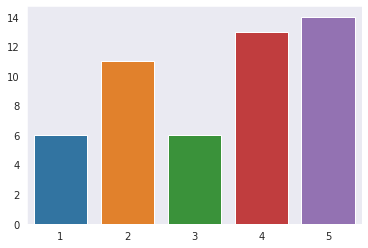

In [11]:
int_set = random_generator.integers(1, 6, 50).tolist()

print('First 10 randomly generated numbers:', int_set[:10])

count_lst = [int_set.count(x) for x in [1,2,3,4,5]]

sns.barplot(x = [1,2,3,4,5], y=count_lst)
plt.show()

As we can see, using a random number generator means some network architectures may end up being significantly more represented than others. To solve this problem, we can create a function which, given a list of items, returns a list of length $n$ with as uniform a distribution of items as possible.

In [12]:
def getUniformList(items_lst, n):
    # items_lst is items to include in list, for example [1, 2, 3, 4, 5] or ['relu', 'tanh']
    # n is length of final list
    
    ret_lst = []
    
    # Add equal number of all the items
    for i in range(0, n//len(items_lst)):
        for item in items_lst:
            ret_lst.append(item)
            
    # If n cannot be divided perfectly by the number of items, use random number generator to add final items to 
    # list to make up the list size to n
    if (n%len(items_lst)) != 0:
        for i in range(0, n%len(items_lst)):
            ret_lst.append(items_lst[random_generator.integers(0, len(items_lst), 1)[0]])
    
    # Finally we need to shuffle our list
    random.shuffle(ret_lst)
    
    return ret_lst

First 10 randomly generated numbers: [4, 3, 3, 1, 2, 5, 4, 3, 1, 5]


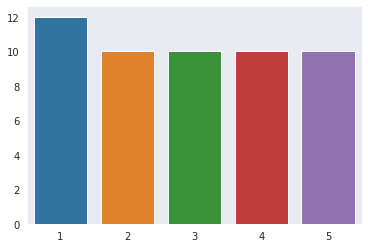

In [13]:
layers_lst = getUniformList([1, 2, 3, 4, 5], 52)

print('First 10 randomly generated numbers:', layers_lst[:10])

count_lst = [layers_lst.count(x) for x in [1,2,3,4,5]]

sns.barplot(x = [1,2,3,4,5], y=count_lst)
plt.show()

We can use this function to ensure categorical hyperparameters have an equal split of hyperparameter options across our trials.

### 2.2.4 Structure of hyperparameter selection

Hyperparameter variables are defined as such:

* First we define the variables which every model in the trial requires, and which can be defined in a single way for all the models: layer structure, number of hidden layers, activation function, batch size, learning rate, whether dropout layers are allowed, and whether the optimiser will have momentum.
* We create a dataframe with a row for each model, which holds the values we have defined above. Variables which we have not yet defined have a default variable such as 0.
* The remaining variables are defined using dataframe indicies of model subsets. For example, we retrieve all indicies for models which have a third dense layer. 50% of these models will be defined as having a dropout layer after the third dense layer, while 50% will not have a dropout layer after the third dense layer. Working this way - defining variables with consideration to other variables - means we can retain a more balanced distribution of values. 
* Ascending and descending layer size network structures have a definition such that, if an ascending network has 5 layers, layer five has five times as many neurons as layer one, layer four has four times as many neurons as layer one, etc. Some practitioners may use powers of two to define ascending/descending layers (e.g. layer sizes 8, 16, 32 etc), however with some of the seed values already being quite large, I felt this would create networks which were much too large (or small) at times. Therefore I chose to scale by simple integer multiplication or division.

The main search function:

In [15]:
# Quasi-random search

def QRSearch(n_trials, hp_ranges, x_train, y_train, x_valid, y_valid):
    
    # We will first get a list of n (where n = number of trials) values for each hyperparameter 

    # Categorical-type hyperparameters
    
    # Layer structure
    layer_structure = getUniformList(['Uniform', 'Uniform', 'Ascending min', 'Ascending max', 'Descending min', 
                                      'Descending max', 'Random', 'Random', 'Random', 'Random'], n_trials)

    # Number of hidden layers
    hidden_layers = getUniformList([2, 3, 4, 5], n_trials)
    
    # Create true/false variable for layers 3-5 based on number of layers
    L3 = []
    L4 = []
    L5 = []
    
    for l in hidden_layers:
        L3v = True
        L4v = True
        L5v = True
        
        if l < 5:
            L5v = False
        if l < 4:
            L4v = False
        if l < 3:
            L3v = False
            
        L3.append(L3v)
        L4.append(L4v)
        L5.append(L5v)
    

    # Activation functions
    activations = getUniformList(hp_ranges.get('Activations'), n_trials)

    # Allow drop out layers?
    allow_do = getUniformList([False, True, True, True], n_trials)

    # Allow momentum?
    allow_mom = getUniformList([False, True, True, True], n_trials)
    
    
    # Make a sampler of dimension 1 for Sobol values
    sampler_1 = Sobol(d=1, scramble=True)
    
    
    # Get learning rate and momentum values
    lr_Sobol = qmc.scale(sampler_1.random(n_trials), hp_ranges.get('Learning rate')[0], 
                         hp_ranges.get('Learning rate')[1])
    bs_Sobol = qmc.scale(sampler_1.random(n_trials), hp_ranges.get('Batch size')[0], 
                         hp_ranges.get('Batch size')[1])
    
    # Lists to hold values for each model
    LR = []
    BS = []

    # Sobol sequences are arrays within which each value is in a list, so we need to convert this to a single list
    for i in lr_Sobol:
        LR.append(i[0])
        
    for i in bs_Sobol:
        # Batch size must be an integer
        BS.append(int(round(i[0], 0)))
    
    # Put values in a dataframe so we can iterate through the dataframe to define the remaining values
    # We set defaults at this stage for values we have not defined
    trials = pd.DataFrame({'Structure': layer_structure, 'Number of hidden layers': hidden_layers, 
                           'Activation': activations, 'Allow dropout layers?': allow_do, 
                           'Allow momentum?': allow_mom, 'L3': L3, 'L4': L4, 'L5': L5, 
                           'D1': False, 'D2': False, 'D3': False, 'D4': False, 'D5': False, 
                           'L1N': 0, 'L2N': 0, 'L3N': 0, 'L4N': 0, 'L5N': 0, 
                           'D1R': 0, 'D2R': 0, 'D3R': 0, 'D4R': 0, 'D5R': 0, 
                           'Learning rate': LR, 'Momentum': 0.0, 'Batch size': BS})
    
    
    # Momenum values
    # We only want to set a non-zero momentum value where allow momentum = TRUE
    trials_am = trials[trials['Allow momentum?']==True]
    mom_Sobol = qmc.scale(sampler_1.random(len(trials_am)), hp_ranges.get('Momentum')[0], hp_ranges.get('Momentum')[1])
    count = 0
    for i in trials_am.index:
        trials.loc[i, 'Momentum'] = mom_Sobol[count][0]
        count += 1
    
    
    # Whether to add a dropout layer after a dense layer
    
    # Get subsets where layer size = 3, 4, 5
    trials_L3 = trials[trials['L3']==True]
    trials_L4 = trials[trials['L4']==True]
    trials_L5 = trials[trials['L5']==True]
    
    # Individual dropout layers - True/False distribution
    DO1 = getUniformList([False, True], n_trials)
    DO2 = getUniformList([False, True], n_trials)
    DO3 = getUniformList([False, True], len(trials_L3))
    DO4 = getUniformList([False, True], len(trials_L4))
    DO5 = getUniformList([False, True], len(trials_L5))
    
    for i in trials.index:
        trials.loc[i, 'D1'] = DO1[i]
        trials.loc[i, 'D2'] = DO2[i]
    
    # For the remaining layers need to set a count to iterate through the list 
    count = 0
    for i in trials_L3.index:
        trials.loc[i, 'D3'] = DO3[count]
        count += 1
    
    count = 0
    for i in trials_L4.index:
        trials.loc[i, 'D4'] = DO4[count]
        count += 1
        
    count = 0
    for i in trials_L5.index:
        trials.loc[i, 'D5'] = DO5[count]
        count += 1
    
    
    # Dropout layer rate
    trials_D1 = trials[trials['D1']==True]
    trials_D2 = trials[trials['D2']==True]
    trials_D3 = trials[trials['D3']==True]
    trials_D4 = trials[trials['D4']==True]
    trials_D5 = trials[trials['D5']==True]
    
    # Define dropout rate range
    do_lower = hp_ranges.get('Dropout rate')[0]
    do_upper = hp_ranges.get('Dropout rate')[1]
    
    # Get values
    DO1R = qmc.scale(sampler_1.random(len(trials_D1)), do_lower, do_upper)
    DO2R = qmc.scale(sampler_1.random(len(trials_D2)), do_lower, do_upper)
    DO3R = qmc.scale(sampler_1.random(len(trials_D3)), do_lower, do_upper)
    DO4R = qmc.scale(sampler_1.random(len(trials_D4)), do_lower, do_upper)
    DO5R = qmc.scale(sampler_1.random(len(trials_D5)), do_lower, do_upper)
    
    # Append values to dataframe
    count = 0
    for i in trials_D1.index:
        trials.loc[i, 'D1R'] = DO1R[count]
        count += 1
    
    count = 0
    for i in trials_D2.index:
        trials.loc[i, 'D2R'] = DO2R[count]
        count += 1
    
    count = 0
    for i in trials_D3.index:
        trials.loc[i, 'D3R'] = DO3R[count]
        count += 1
    
    count = 0
    for i in trials_D4.index:
        trials.loc[i, 'D4R'] = DO4R[count]
        count += 1
        
    count = 0
    for i in trials_D5.index:
        trials.loc[i, 'D5R'] = DO5R[count]
        count += 1

    
    # Get later sizes based on layer structure
    # We want to make sure each set of models with a particular structure have a Sobol distribution

    # Define layer size range
    ls_lower = hp_ranges.get('Layer sizes')[0]
    ls_upper = hp_ranges.get('Layer sizes')[1]
    
    # Uniform
    trials_uniform = trials[trials['Structure']=='Uniform']
    uniform_Sobol = qmc.scale(sampler_1.random(len(trials_uniform)), ls_lower, ls_upper)
    count = 0
    for i in trials_uniform.index:
        for layer in ['L1N', 'L2N', 'L3N', 'L4N', 'L5N']:
            trials.loc[i, layer] = int(round(uniform_Sobol[count][0], 0))
        count += 1
    
    # Ascending min - quasirandom number is the smallest value in an ascending network
    trials_ascmin = trials[trials['Structure']=='Ascending min']
    ascmin_Sobol = qmc.scale(sampler_1.random(len(trials_ascmin)), ls_lower, ls_upper)
    count = 0
    for i in trials_ascmin.index:
        layer_count = 1
        for layer in ['L1N', 'L2N', 'L3N', 'L4N', 'L5N']:
            trials.loc[i, layer] = int(round(ascmin_Sobol[count][0], 0)) * layer_count
            layer_count += 1
        count += 1
        
    # Descending max - quasirandom number is the largest value in an descending network
    trials_desmax = trials[trials['Structure']=='Descending max']
    desmax_Sobol = qmc.scale(sampler_1.random(len(trials_desmax)), ls_lower, ls_upper)
    count = 0
    for i in trials_desmax.index:
        layer_count = 1
        for layer in ['L1N', 'L2N', 'L3N', 'L4N', 'L5N']:
            trials.loc[i, layer] = int(round(desmax_Sobol[count][0] / layer_count, 0))
            layer_count += 1
        count += 1
        
    # For 'Ascending max' and 'Descending min' we have to consider number of layers 
    
    # Ascending max - quasirandom number is the largest value in an ascending network
    trials_ascmax = trials[trials['Structure']=='Ascending max']
    ascmax_Sobol = qmc.scale(sampler_1.random(len(trials_ascmax)), ls_lower, ls_upper)
    count = 0
    for i in trials_ascmax.index:
        num_layers = trials_ascmax['Number of hidden layers'][i]
        seed_value = int(round(ascmax_Sobol[count][0], 0))
        if num_layers == 5:
            layer_list = ['L5N', 'L4N', 'L3N', 'L2N', 'L1N']
        elif num_layers == 4:
            layer_list = ['L4N', 'L3N', 'L2N', 'L1N']
        elif num_layers == 3:
            layer_list = ['L3N', 'L2N', 'L1N']
        else:
            layer_list = ['L2N', 'L1N']
        
        layer_count = 1
        for layer in layer_list:
            trials.loc[i, layer] = int(round(ascmax_Sobol[count][0] / layer_count, 0))
            layer_count += 1
        
        count += 1
        
    # Descending min - quasirandom number is the smallest value in an descending network
    trials_desmin = trials[trials['Structure']=='Descending min']
    desmin_Sobol = qmc.scale(sampler_1.random(len(trials_desmin)), ls_lower, ls_upper)
    count = 0
    for i in trials_desmin.index:
        num_layers = trials_desmin['Number of hidden layers'][i]
        seed_value = int(round(desmin_Sobol[count][0], 0))
        if num_layers == 5:
            layer_list = ['L5N', 'L4N', 'L3N', 'L2N', 'L1N']
        elif num_layers == 4:
            layer_list = ['L4N', 'L3N', 'L2N', 'L1N']
        elif num_layers == 3:
            layer_list = ['L3N', 'L2N', 'L1N']
        else:
            layer_list = ['L2N', 'L1N']
        
        layer_count = 1
        for layer in layer_list:
            trials.loc[i, layer] = int(round(desmin_Sobol[count][0], 0)) * layer_count
            layer_count += 1
        
        count += 1
        
    # Random structure 
    sampler_5 = Sobol(d=5, scramble=True)
    trials_random = trials[trials['Structure']=='Random']
    random_Sobol = qmc.scale(sampler_5.random(len(trials_random)), [ls_lower for x in range(0,5)], [ls_upper for x in range(0,5)])
    count = 0
    for i in trials_random.index:
        layer_count = 0
        for layer in ['L1N', 'L2N', 'L3N', 'L4N', 'L5N']:
            trials.loc[i, layer] = int(round(random_Sobol[count][layer_count], 0))
            layer_count += 1
        count += 1
    
    # Run each model and save min loss + max accuracy
    for i in trials.index:
        print("Trialling model", i+1, "of", len(trials))

        # Create and fit model, get loss and accuracy
        hist_dict = modelBuilder(L1N=trials['L1N'][i], 
                                 D1=trials['D1'][i], D1R=trials['D1R'][i],
                                 L2N=trials['L2N'][i], 
                                 D2=trials['D2'][i], D2R=trials['D2R'][i],
                                 L3=trials['L3'][i], L3N=trials['L3N'][i], 
                                 D3=trials['D3'][i], D3R=trials['D3R'][i],
                                 L4=trials['L4'][i], L4N=trials['L4N'][i], 
                                 D4=trials['D4'][i], D4R=trials['D4R'][i],
                                 L5=trials['L5'][i], L5N=trials['L5N'][i], 
                                 D5=trials['D5'][i], D5R=trials['D5R'][i],
                                 OLR=trials['Learning rate'][i], OM=trials['Momentum'][i], 
                                 AVN=trials['Activation'][i], BS=trials['Batch size'][i],
                                 x_train=x_train, y_train=y_train, x_valid=x_valid, y_valid=y_valid,
                                 model_type='Trials')

        valid_loss = pd.DataFrame({'Epoch': range(1, len(hist_dict['val_loss'])+1), 'Loss': hist_dict['val_loss']})
        valid_acc = pd.DataFrame({'Epoch': range(1, len(hist_dict['val_accuracy'])+1), 'Accuracy': hist_dict['val_accuracy']})
        
        trials.loc[i, 'Min val loss'] = valid_loss.sort_values(by=['Loss']).head(1).reset_index()['Loss'][0]
        trials.loc[i, 'Min val loss epoch'] = valid_loss.sort_values(by=['Loss']).head(1).reset_index()['Epoch'][0]
        trials.loc[i, 'Max val accuracy'] = valid_acc.sort_values(by=['Accuracy'], ascending=False).head(1).reset_index()['Accuracy'][0]
        trials.loc[i, 'Max val accuracy epoch'] = valid_acc.sort_values(by=['Accuracy'], ascending=False).head(1).reset_index()['Epoch'][0]
        
        best_trial = trials.sort_values(by=['Min val loss']).head(1)
    
    return best_trial, trials

# 3 Running the program <a class="anchor" id="run"></a>

We can now define our hyperparameter ranges and run hyperparameter optimisation program:

In [31]:
hp_ranges = {'Activations': ['relu', 'tanh', 'sigmoid'], 'Layer sizes': [20, 1500], 'Dropout rate': [0, 0.7],
            'Learning rate': [0.0005, 0.005], 'Momentum': [0, 1], 'Batch size': [5, 600]}

start_time = time.time()

best_trial, all_trials = QRSearch(n_trials=300, hp_ranges=hp_ranges, x_train=x_train, y_train=y_train, 
                                  x_valid=x_valid, y_valid=y_valid)

end_time = time.time()

time_taken = end_time - start_time

print('Time taken:', time_taken, 'seconds')

Trialling model 1 of 300
Trialling model 2 of 300
Trialling model 3 of 300
Trialling model 4 of 300
Trialling model 5 of 300
Trialling model 6 of 300
Trialling model 7 of 300
Trialling model 8 of 300
Trialling model 9 of 300
Trialling model 10 of 300
Trialling model 11 of 300
Trialling model 12 of 300
Trialling model 13 of 300
Trialling model 14 of 300
Trialling model 15 of 300
Trialling model 16 of 300
Trialling model 17 of 300
Trialling model 18 of 300
Trialling model 19 of 300
Trialling model 20 of 300
Trialling model 21 of 300
Trialling model 22 of 300
Trialling model 23 of 300
Trialling model 24 of 300
Trialling model 25 of 300
Trialling model 26 of 300
Trialling model 27 of 300
Trialling model 28 of 300
Trialling model 29 of 300
Trialling model 30 of 300
Trialling model 31 of 300
Trialling model 32 of 300
Trialling model 33 of 300
Trialling model 34 of 300
Trialling model 35 of 300
Trialling model 36 of 300
Trialling model 37 of 300
Trialling model 38 of 300
Trialling model 39 of

In [32]:
# Save results

best_trial.to_csv('best_trial.csv')
!cp best_trial.csv "drive/My Drive/"

all_trials.to_csv('all_trials.csv')
!cp all_trials.csv "drive/My Drive/"

We can now see the model which performed best at trial stage, and which loss/accuracy it achieved:

In [33]:
best_trial.reset_index(inplace=True, drop=True)

for col in best_trial:
    print(col, ':', best_trial[col][0])

Structure : Ascending max
Number of hidden layers : 2
Activation : sigmoid
Allow dropout layers? : True
Allow momentum? : True
L3 : False
L4 : False
L5 : False
D1 : True
D2 : False
D3 : False
D4 : False
D5 : False
L1N : 163
L2N : 325
L3N : 0
L4N : 0
L5N : 0
D1R : 0.1725827321410179
D2R : 0.0
D3R : 0.0
D4R : 0.0
D5R : 0.0
Learning rate : 0.0030597063601017003
Momentum : 0.19803881645202637
Batch size : 544
Min val loss : 0.28139692544937134
Min val loss epoch : 44.0
Max val accuracy : 0.8985000252723694
Max val accuracy epoch : 44.0


# 4 Evaluating the best performing model using test data <a class="anchor" id="test"></a>

We will now evaulate our best performing model using the test data.

In [34]:
modelBuilder(L1N=best_trial['L1N'][0], 
             D1=best_trial['D1'][0], D1R=best_trial['D1R'][0],
             L2N=best_trial['L2N'][0], 
             D2=best_trial['D2'][0], D2R=best_trial['D2R'][0],
             L3=best_trial['L3'][0], L3N=best_trial['L3N'][0], 
             D3=best_trial['D3'][0], D3R=best_trial['D3R'][0],
             L4=best_trial['L4'][0], L4N=best_trial['L4N'][0], 
             D4=best_trial['D4'][0], D4R=best_trial['D4R'][0],
             L5=best_trial['L5'][0], L5N=best_trial['L5N'][0], 
             D5=best_trial['D5'][0], D5R=best_trial['D5R'][0],
             OLR=best_trial['Learning rate'][0], OM=best_trial['Momentum'][0], 
             AVN=best_trial['Activation'][0], BS=best_trial['Batch size'][0],
             train_images=train_images, train_labels=train_labels, 
             test_images=test_images, test_labels=test_labels, test_epochs=int(best_trial['Max val accuracy epoch'][0]),
             model_type='Test')

Epoch 1/44
111/111 [==============================] - 1s 3ms/step - loss: 0.8926 - accuracy: 0.6723
Epoch 2/44
111/111 [==============================] - 0s 3ms/step - loss: 0.5341 - accuracy: 0.8015
Epoch 3/44
111/111 [==============================] - 0s 3ms/step - loss: 0.4709 - accuracy: 0.8271
Epoch 4/44
111/111 [==============================] - 0s 3ms/step - loss: 0.4353 - accuracy: 0.8379
Epoch 5/44
111/111 [==============================] - 0s 3ms/step - loss: 0.4103 - accuracy: 0.8483
Epoch 6/44
111/111 [==============================] - 0s 3ms/step - loss: 0.3946 - accuracy: 0.8543
Epoch 7/44
111/111 [==============================] - 0s 3ms/step - loss: 0.3802 - accuracy: 0.8582
Epoch 8/44
111/111 [==============================] - 0s 3ms/step - loss: 0.3653 - accuracy: 0.8643
Epoch 9/44
111/111 [==============================] - 0s 3ms/step - loss: 0.3540 - accuracy: 0.8692
Epoch 10/44
111/111 [==============================] - 0s 3ms/step - loss: 0.3455 - accuracy: 0.8716

# 5 Conclusion and evaluation <a class="anchor" id="conclusion"></a>

Using my hyperparameter optimisation program, the best model during trialing achieved a maximum validation accuracy of 0.899. In the test evaluation, the model achieved an accuracy of 0.877. 

Bergstra and Bengio [1] noted that random search was generally not as effective as a human expert using a combination of manual and grid search because a person learns from the results of previous experiments and is able to adapt their approach. Interestingly, I previously used the manual/grid approach to optimise a neural network on the same data set, and the maximum validation accuracy I achieved was also 0.899 - although it should be noted that once this program was built, this time I got to the same validation accuracy much quicker than through manual and grid search! 

There are now approaches such as Bayesian Optimisation, which use information from previous trials to attempt to identify which hyperparameter values may reduce the loss of a model, which have an advantage over random search methods.

One of the elements I found difficult during this project was picking suitable ranges for hyperparameters when calling the function. On the one hand, it seems prudent to pick a wide range, in case your selection excludes the optimum for a hyperparameter. On the other hand, very large ranges may suffer from the grid search problem of missing the optimum in the gap between values. A potential improvement on the program I have written is: after a certain number of models have been trialed (for example, 100 models), for the program to restrict the hyperparameter ranges for the next set of models based on the hyperparameter values of the best performing models of the previous set. However, it is unclear how significant this reduction in range would be, and if there are any potential drawbacks to this method (for example, inadvertently excluding the optimum for a hyperparameter early on). 

# 6 References <a class="anchor" id="references"></a>

[1] Bergstra, J., & Bengio, Y. (2012). Random Search for Hyper-Parameter Optimization. J. Mach. Learn. Res., 13, 281-305.  
[2] https://scipy.github.io/devdocs/reference/generated/scipy.stats.qmc.Sobol.html#re15be05a07a0-3. 

Other resources used:

* T. Blackwell, *Artificial Intelligence Lectures and Labs*, London: Goldsmiths,University of London, 2021.
* F. Chollet, *Deep Learning with Python*, Shelter Island: Manning, 2018.
* M. Nielsen, *Neural Networks and Deep Learning* [Online]. Avaliable: http://neuralnetworksanddeeplearning.com/
* Zalando Research, *Fashion-MNIST* [Online]. Avaliable: https://github.com/zalandoresearch/fashion-mnist